# Mixed Logit with correlations

Using swissmetro data, comparing results to biogeme (Bierlaire, M. (2018). PandasBiogeme: a short introduction. EPFL (Transport and Mobility Laboratory, ENAC))


So mnl is identical. mixed param for travel time too, for both with and w/o panel. MXL for both cost and time random is also identical for both w and w/o panel.

It's really just a problem with ECs. Actually, that's because they are not identified. Three alternatives, so only one sd is identified. one is zero and is 1. garh. for correlated vars, one off-diag of all three would be identified.

In [1]:
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp

from jaxlogit.mixed_logit import MixedLogit
from jaxlogit.utils import wide_to_long

In [2]:
#  64bit precision
jax.config.update("jax_enable_x64", True)

## Swissmetro Dataset

In [3]:
df_wide = pd.read_table("http://transp-or.epfl.ch/data/swissmetro.dat", sep='\t')

# Keep only observations for commute and business purposes that contain known choices
df_wide = df_wide[(df_wide['PURPOSE'].isin([1, 3]) & (df_wide['CHOICE'] != 0))]

df_wide['custom_id'] = np.arange(len(df_wide))  # Add unique identifier
df_wide['CHOICE'] = df_wide['CHOICE'].map({1: 'TRAIN', 2:'SM', 3: 'CAR'})

# biogeme data prep
#exclude = ((PURPOSE != 1) * (PURPOSE != 3) + (CHOICE == 0)) > 0
exclude = ((df_wide['PURPOSE'] != 1) * (df_wide['PURPOSE'] != 3) + (df_wide['CHOICE'] == 0)) > 0
print(f"Excluding {exclude.sum()} observations from {len(df_wide)} total observations.")
df_wide = df_wide[~exclude]

Excluding 0 observations from 6768 total observations.


In [4]:
#TRAIN_AV_SP = database.define_variable('TRAIN_AV_SP', TRAIN_AV * (SP != 0))
df_wide['TRAIN_AV'] = df_wide['TRAIN_AV'] * (df_wide['SP'] != 0)
# CAR_AV_SP = database.define_variable('CAR_AV_SP', CAR_AV * (SP != 0))
df_wide['CAR_AV'] = df_wide['CAR_AV'] * (df_wide['SP'] != 0)

In [5]:
df = wide_to_long(df_wide, id_col='custom_id', alt_name='alt', sep='_',
                  alt_list=['TRAIN', 'SM', 'CAR'], empty_val=0,
                  varying=['TT', 'CO', 'HE', 'AV', 'SEATS'], alt_is_prefix=True)

In [6]:
df['ASC_TRAIN'] = np.where(df['alt'] == 'TRAIN', 1, 0)
df['ASC_CAR'] = np.where(df['alt'] == 'CAR', 1, 0)
df['ASC_SM'] = np.where(df['alt'] == 'SM', 1, 0)

df['TT'] = df['TT'] / 100.0
df['CO'] = df['CO'] / 100.0

annual_pass = (df['GA'] == 1) & (df['alt'].isin(['TRAIN', 'SM']))
df.loc[annual_pass, 'CO'] = 0  # Cost zero for pass holders

## Now above before long to wide
#CAR_AV_SP = database.define_variable('CAR_AV_SP', CAR_AV * (SP != 0))
#TRAIN_AV_SP = database.define_variable('TRAIN_AV_SP', TRAIN_AV * (SP != 0))
#df.loc[(df['SP'] == 0) & (df['alt'].isin(['CAR', 'TRAIN'])), 'AV'] = 0

In [7]:
df.custom_id.unique().max() + 1

np.int64(6768)

In [8]:
# so setting sd of car and train to zero means we get the same result. WTF is this important? Aren't they all relative? Actually, no. What happens for panel data? All are identified, it seems.
# try different fixed sd.car: record init LL and solution. Looks like solution is the same for 0, 0.4, and 1? double-check! simply means it is not identified, but why the big difference for bg? num draws?

In [9]:
# model.coeff_names
init_vals = None  #[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]

In [10]:
varnames = ['ASC_SM', 'ASC_CAR', 'ASC_TRAIN', 'TT', 'CO']

#randvars = {'CO': 'n', 'TT': 'n'}  
randvars = {'ASC_SM': 'n', 'ASC_CAR': 'n', 'ASC_TRAIN': 'n'}

# train is smallest when none are ifxed -> has to be smallest
fixedvars = {'ASC_TRAIN': 0.0}  #, 'corr.TT.CO': 0.0}  #, 'sd.ASC_TRAIN': 0.0, 'sd.ASC_CAR': 0.0}  #}  #, 'sd.ASC_CAR': 1.0}  # Mean and variance of SM is fixed to 0, 'sd.ASC_CAR': 0.437869

do_panel = False

model = MixedLogit()
res = model.fit(
    X=df[varnames],
    y=df['CHOICE'],
    varnames=varnames,
    alts=df['alt'],
    ids=df['custom_id'],
    avail=df['AV'],
    panels=None if do_panel is False else df["ID"],
    randvars=randvars,
    n_draws=2000,
    fixedvars=fixedvars,
    init_coeff=init_vals,
    include_correlations=False,  # Enable correlation between random parameters
    optim_method='trust-region',  # 'L-BFGS-B'
)
model.summary()

2025-07-13 20:07:05,755 INFO jaxlogit.mixed_logit: Starting data preparation, including generation of 2000 random draws for each random variable and observation.
INFO:2025-07-13 20:07:06,255:jax._src.xla_bridge:752: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2025-07-13 20:07:06,255 INFO jax._src.xla_bridge: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2025-07-13 20:07:13,601 INFO jaxlogit.mixed_logit: Shape of draws: (6768, 3, 2000), number of draws: 2000
2025-07-13 20:07:13,602 INFO jaxlogit.mixed_logit: Shape of Xdf: (6768, 2, 2), shape of Xdr: (6768, 2, 3)
2025-07-13 20:07:13,603 INFO jaxlogit.mixed_logit: Compiling log-likelihood function.
2025-07-13 20:07:13,961 INFO jaxlogit.mixed_logit: Compilation finished, init neg_loglike = 7017.40, params= [(np.str_('ASC_SM'), Array(0.1, dtype=float64

Loss on this step: 7017.403837161417, Loss on the last accepted step: 0.0, Step size: 1.0
Loss on this step: 1788933.551879583, Loss on the last accepted step: 7017.403837161417, Step size: 0.25
Loss on this step: 1112431.1853748779, Loss on the last accepted step: 7017.403837161417, Step size: 0.0625
Loss on this step: 304294.42034264264, Loss on the last accepted step: 7017.403837161417, Step size: 0.015625
Loss on this step: 84235.30877935124, Loss on the last accepted step: 7017.403837161417, Step size: 0.00390625
Loss on this step: 21000.80765728151, Loss on the last accepted step: 7017.403837161417, Step size: 0.0009765625
Loss on this step: 6411.406752406871, Loss on the last accepted step: 7017.403837161417, Step size: 0.0009765625
Loss on this step: 5470.330609456536, Loss on the last accepted step: 6411.406752406871, Step size: 0.0009765625
Loss on this step: 5399.815340893587, Loss on the last accepted step: 5470.330609456536, Step size: 0.0009765625
Loss on this step: 5368.

2025-07-13 20:07:49,326 INFO jaxlogit.mixed_logit: Optimization finished, success = True, final loglike = -5255.46, final gradient max = 4.50e-10, norm = 5.58e-10.
2025-07-13 20:07:49,327 INFO jaxlogit.mixed_logit: Calculating gradient of individual log-likelihood contributions
2025-07-13 20:07:54,089 INFO jaxlogit.mixed_logit: Calculating H_inv
2025-07-13 20:08:02,672 INFO jaxlogit._choice_model: Post fit processing
/home/jzill/code/jaxlogit/jaxlogit/_choice_model.py:104: RuntimeWarning: invalid value encountered in sqrt
  self.stderr = np.sqrt(np.diag(self.covariance))
2025-07-13 20:08:03,109 INFO jaxlogit._choice_model: Optimization terminated successfully.


    Message: 
    Iterations: 75
    Function evaluations: 131
Estimation time= 57.3 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
ASC_SM                  1.2545633     0.1088799    11.5224533      1.95e-30 ***
ASC_CAR                 0.7547490     0.0580589    12.9997116      3.51e-38 ***
ASC_TRAIN               0.0000000     0.0000000           nan           nan    
TT                     -1.7130784     0.0967915   -17.6986446      1.48e-68 ***
CO                     -1.7638536     0.1023472   -17.2340277      3.57e-65 ***
sd.ASC_SM               3.1599420     0.2653872    11.9069109      2.29e-32 ***
sd.ASC_CAR            -24.7148028 826654.7284579    -0.0000299             1    
sd.ASC_TRAIN          -25.2825273           nan           nan           nan    
--------------------------------------

In [11]:
model.__dict__

{'coeff_names': array(['ASC_SM', 'ASC_CAR', 'ASC_TRAIN', 'TT', 'CO', 'sd.ASC_SM',
        'sd.ASC_CAR', 'sd.ASC_TRAIN'], dtype='<U12'),
 'coeff_': Array([  1.25456326,   0.75474899,   0.        ,  -1.71307838,
         -1.76385362,   3.15994199, -24.71480277, -25.28252733],      dtype=float64),
 'stderr': array([1.08879874e-01, 5.80589022e-02, 0.00000000e+00, 9.67915016e-02,
        1.02347150e-01, 2.65387221e-01, 8.26654728e+05,            nan]),
 'zvalues': Array([ 1.15224533e+01,  1.29997116e+01,             nan, -1.76986446e+01,
        -1.72340277e+01,  1.19069109e+01, -2.98973706e-05,             nan],      dtype=float64),
 'pvalues': array([1.95230050e-30, 3.50923426e-38,            nan, 1.47883763e-68,
        3.57463603e-65, 2.28920264e-32, 9.99976146e-01,            nan]),
 'loglikelihood': Array(-5255.46243601, dtype=float64),
 'total_fun_eval': Array(131, dtype=int64, weak_type=True),
 '_rvidx': array([ True,  True,  True, False, False]),
 '_rvdist': ['n', 'n', 'n'],
 'X_ra

In [11]:
## bounds = False
# Array([ 1.00182804e+00,  3.83997554e-01,  0.00000000e+00, -1.77705018e+00,
#       -1.86630446e+00, -1.54365787e-01,  3.39299844e+00, -3.04477145e-03,
#       2.57124803e-01,  1.97240984e-01,  2.90610691e+00], dtype=float64)

In [11]:
#rray([ 0.24806196,  0.38807779,  0.        , -2.90758556, -2.23638878,
#        2.14518692,  1.99569859,  0.84636589])
res['x']

Array([  1.25456326,   0.75474899,   0.        ,  -1.71307838,
        -1.76385362,   3.15994199, -24.71480277, -25.28252733],      dtype=float64)

In [12]:
(
    betas,
    Xdf,
    Xdr,
    panels,
    draws,
    weights,
    avail,
    scale_d,
    mask,
    values_for_mask,
    mask_chol,
    values_for_chol_mask,
    rvidx,
    rand_idx,
    fixed_idx,
    num_panels,
    idx_ln_dist,
    coef_names,
) = model.data_prep_for_fit(
    X=df[varnames],
    y=df['CHOICE'],
    varnames=varnames,
    alts=df['alt'],
    ids=df['custom_id'],
    randvars=randvars,
    weights=None,
    avail=df['AV'],
    panels=None if do_panel is False else df["ID"],
    init_coeff=init_vals,
    maxiter=2000,
    random_state=123,
    n_draws=2000,
    halton=True,
    halton_opts=None,
    fixedvars=fixedvars,
    scale_factor=None,
    include_correlations=False,
)

2025-07-13 17:10:43,491 INFO jaxlogit.mixed_logit: Starting data preparation, including generation of 2000 random draws for each random variable and observation.


In [13]:
mask, mask_chol

(Array([2], dtype=int32), None)

In [14]:
values_for_mask, values_for_chol_mask

(Array([0], dtype=int32), None)

In [15]:
coef_names[5].startswith('sd.')

True

In [16]:
coef_names[len(model._rvidx)]

np.str_('sd.ASC_SM')

In [17]:
jnp.array([0.0, 1.0], dtype=jnp.int32)

Array([0, 1], dtype=int32)

In [12]:
res = model.fit(
    X=df[varnames],
    y=df['CHOICE'],
    varnames=varnames,
    alts=df['alt'],
    ids=df['custom_id'],
    avail=df['AV'],
    panels=None if do_panel is False else df["ID"],
    randvars=randvars,
    n_draws=2000,
    fixedvars=fixedvars,
    init_coeff=init_vals,
    include_correlations=True,  # Enable correlation between random parameters
    use_bounds=False,
    optim_method='trust-region',  # 'L-BFGS-B'
)

2025-07-11 18:58:13,373 INFO jaxlogit.mixed_logit: Starting data preparation, including generation of 2000 random draws for each random variable and observation.
2025-07-11 18:58:17,673 INFO jaxlogit.mixed_logit: Shape of draws: (6768, 2, 2000), number of draws: 2000
2025-07-11 18:58:17,674 INFO jaxlogit.mixed_logit: Shape of Xdf: (6768, 2, 3), shape of Xdr: (6768, 2, 2)
2025-07-11 18:58:17,675 INFO jaxlogit.mixed_logit: Compiling log-likelihood function.
2025-07-11 18:58:17,945 INFO jaxlogit.mixed_logit: Compilation finished, init neg_loglike = 6854.66, params= [(np.str_('ASC_SM'), Array(0., dtype=float64)), (np.str_('ASC_CAR'), Array(0., dtype=float64)), (np.str_('ASC_TRAIN'), Array(0., dtype=float64)), (np.str_('TT'), Array(0., dtype=float64)), (np.str_('CO'), Array(0., dtype=float64)), (np.str_('sd.TT'), Array(1., dtype=float64)), (np.str_('sd.CO'), Array(1., dtype=float64)), (np.str_('chol.TT.CO'), Array(1., dtype=float64))]
2025-07-11 18:58:17,946 INFO jaxlogit._optimize: Running

Loss on this step: 6854.656381435868, Loss on the last accepted step: 0.0, Step size: 1.0
Loss on this step: 1826744.4321811115, Loss on the last accepted step: 6854.656381435868, Step size: 0.25
Loss on this step: 1273386.9212413018, Loss on the last accepted step: 6854.656381435868, Step size: 0.0625
Loss on this step: 331837.2181703817, Loss on the last accepted step: 6854.656381435868, Step size: 0.015625
Loss on this step: 84587.09923980582, Loss on the last accepted step: 6854.656381435868, Step size: 0.00390625
Loss on this step: 20496.337752662046, Loss on the last accepted step: 6854.656381435868, Step size: 0.0009765625
Loss on this step: 6342.1324213571625, Loss on the last accepted step: 6854.656381435868, Step size: 0.0009765625
Loss on this step: 5455.370018051781, Loss on the last accepted step: 6342.1324213571625, Step size: 0.0009765625
Loss on this step: 5349.128726099956, Loss on the last accepted step: 5455.370018051781, Step size: 0.0009765625
Loss on this step: 52

2025-07-11 18:59:10,190 INFO jaxlogit.mixed_logit: Optimization finished, success = True, final loglike = -5140.71
2025-07-11 18:59:10,192 INFO jaxlogit.mixed_logit: Calculating gradient of individual log-likelihood contributions
2025-07-11 18:59:16,533 INFO jaxlogit.mixed_logit: Calculating H_inv
2025-07-11 18:59:21,251 INFO jaxlogit._choice_model: Post fit processing


In [13]:
prosb = model.predict(
    X=df[varnames],
    varnames=varnames,
    init_coeff=res['x'],
    alts=df['alt'],
    ids=df['custom_id'],
    avail=df['AV'],
    panels=None if do_panel is False else df["ID"],
    randvars=randvars,
    n_draws=1000,
    include_correlations=True,  # Enable correlation between random parameters
)

# these have to be in same order for this to work - enforced in long_format consistency check, use it here
uq_alts, idx = np.unique(df['alt'], return_index=True)
uq_alts = uq_alts[np.argsort(idx)]


probs = pd.DataFrame(prosb, columns=uq_alts, index=np.unique(df['custom_id']))

2025-07-11 18:59:21,284 INFO jaxlogit.mixed_logit: Starting data preparation, including generation of 1000 random draws for each random variable and observation.


In [14]:
df_wide.CHOICE.value_counts(normalize=True)

CHOICE
SM       0.604314
CAR      0.261525
TRAIN    0.134161
Name: proportion, dtype: float64

In [15]:
probs.mean()

TRAIN    0.131201
SM       0.602500
CAR      0.266299
dtype: float64

array([[<Axes: title={'center': 'TRAIN'}>,
        <Axes: title={'center': 'SM'}>],
       [<Axes: title={'center': 'CAR'}>, <Axes: >]], dtype=object)

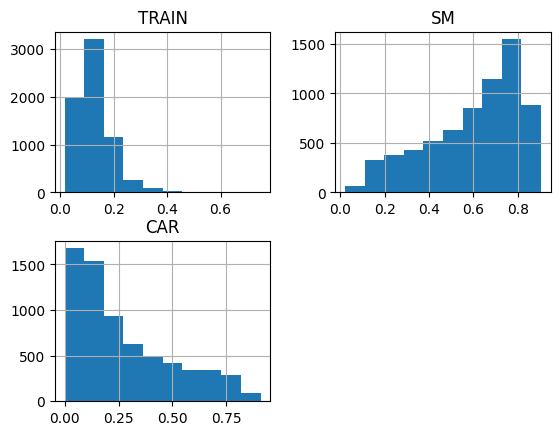

In [16]:
probs.hist()

# DEV CORNER

In [74]:
X=df[varnames]
y=df['CHOICE']
varnames=varnames
alts=df['alt']
ids=df['custom_id']
avail=df['AV']
panels=None if do_panel is False else df["ID"]
randvars=randvars
n_draws=1000
fixedvars=fixedvars
init_coeff=init_vals
include_correlations=False
use_bounds=False
# defaults
weights=None
maxiter=2000
random_state=None
halton=True
halton_opts=None
fixedvars=None
scale_factor=None

(
    betas,
    Xdf,
    Xdr,
    panels,
    draws,
    weights,
    avail,
    scale_d,
    mask,
    values_for_mask,
    rvidx,
    rand_idx,
    fixed_idx,
    num_panels,
    idx_ln_dist,
    coef_names,
) = model.data_prep_for_fit(
    X,
    y,
    varnames,
    alts,
    ids,
    randvars,
    weights=weights,
    avail=avail,
    panels=panels,
    init_coeff=init_coeff,
    maxiter=maxiter,
    random_state=random_state,
    n_draws=n_draws,
    halton=halton,
    halton_opts=halton_opts,
    fixedvars=fixedvars,
    scale_factor=scale_factor,
    include_correlations=include_correlations,
)

fargs = (
    Xdf,
    Xdr,
    panels,
    draws,
    weights,
    avail,
    scale_d,
    mask,
    values_for_mask,
    rvidx,
    rand_idx,
    fixed_idx,
    num_panels,
    idx_ln_dist,
    include_correlations,
)

import logging
import jaxlogit
logger = logging.getLogger("jaxlogit")

if idx_ln_dist.shape[0] > 0:
    logger.info(
        f"Lognormal distributions found for {idx_ln_dist.shape[0]} random variables, applying transformation."
    )

if scale_d is not None:
    logger.info("Scaling is in use, scaling the data by the scale factor.")

if panels is not None:
    logger.info(f"Data contains {num_panels} panels, using segment_sum for panel-wise log-likelihood.")

logger.info(f"Shape of draws: {draws.shape}, number of draws: {n_draws}")
logger.info(f"Shape of Xdf: {Xdf.shape}, shape of Xdr: {Xdr.shape}")

logger.info("Compiling log-likelihood function.")
jit_neg_loglike = jax.jit(jaxlogit.mixed_logit.neg_loglike, static_argnames=["num_panels", "include_correlations"])
neg_loglik_and_grad = jax.value_and_grad(jit_neg_loglike, argnums=0)
init_loglik = neg_loglik_and_grad(betas, *fargs)
logger.info(
    f"Compilation finished, init neg_loglike = {init_loglik[0]:.2f}, params= {list(zip(coef_names, betas))}"
)

2025-07-08 04:12:51,575 INFO jaxlogit.mixed_logit: Starting data preparation, including generation of 1000 random draws for each random variable and observation.
2025-07-08 04:12:54,800 INFO jaxlogit: Shape of draws: (6768, 3, 1000), number of draws: 1000
2025-07-08 04:12:54,801 INFO jaxlogit: Shape of Xdf: (6768, 2, 2), shape of Xdr: (6768, 2, 3)
2025-07-08 04:12:54,802 INFO jaxlogit: Compiling log-likelihood function.
2025-07-08 04:12:55,289 INFO jaxlogit: Compilation finished, init neg_loglike = 6964.58, params= [(np.str_('ASC_SM'), Array(0., dtype=float64)), (np.str_('ASC_CAR'), Array(0., dtype=float64)), (np.str_('ASC_TRAIN'), Array(0., dtype=float64)), (np.str_('CO'), Array(0., dtype=float64)), (np.str_('TT'), Array(0., dtype=float64)), (np.str_('sd.ASC_SM'), Array(1., dtype=float64)), (np.str_('sd.ASC_CAR'), Array(1., dtype=float64)), (np.str_('sd.ASC_TRAIN'), Array(1., dtype=float64))]


In [65]:
sd_start_idx = len(rvidx)
sd_slice_size = len(rand_idx)

In [66]:
model._varnames, rvidx, coef_names, rand_idx, fixed_idx, sd_start_idx, sd_slice_size

([np.str_('ASC_SM'),
  np.str_('ASC_CAR'),
  np.str_('ASC_TRAIN'),
  np.str_('CO'),
  np.str_('TT')],
 Array([ True,  True,  True, False, False], dtype=bool),
 array(['ASC_SM', 'ASC_CAR', 'ASC_TRAIN', 'CO', 'TT', 'sd.ASC_SM',
        'sd.ASC_CAR', 'sd.ASC_TRAIN'], dtype='<U12'),
 Array([0, 1, 2], dtype=int64),
 Array([3, 4], dtype=int64),
 5,
 3)

In [68]:
betas[rand_idx]

Array([0., 0., 0.], dtype=float64)

In [69]:
jax.lax.dynamic_slice(
    betas, (sd_start_idx,), (sd_slice_size,)
)  # Extract the std devs from the betas vector

Array([1., 1., 1.], dtype=float64)

In [97]:
df_wide.head(1)

,GROUP,SURVEY,SP,ID,PURPOSE,FIRST,TICKET,WHO,LUGGAGE,AGE,...,TRAIN_CO,TRAIN_HE,SM_TT,SM_CO,SM_HE,SM_SEATS,CAR_TT,CAR_CO,CHOICE,custom_id
0,2,0,1,1,1,0,1,1,0,3,...,48,120,63,52,20,0,117,65,SM,0


In [107]:
Xdf[0]

Array([[-0.04,  0.49],
       [ 0.13,  0.54]], dtype=float64)

In [ ]:
Xdr[0]  # first one: -asccar + asc_train, second one -asc_car + asc_sm

Array([[-1.,  0.,  1.],
       [-1.,  1.,  0.]], dtype=float64)

In [106]:
X.head(3), y.head(3)

(   ASC_SM  ASC_CAR  ASC_TRAIN    CO    TT
 0       0        0          1  0.48  1.12
 1       1        0          0  0.52  0.63
 2       0        1          0  0.65  1.17,
 0    SM
 1    SM
 2    SM
 Name: CHOICE, dtype: object)

In [ ]:
Xdr[-1]  # so first one: asc_car - asc_train, second one: asc_sm - asc_train

Array([[ 1.,  0., -1.],
       [ 0.,  1., -1.]], dtype=float64)

In [96]:
df_wide.tail(1)

,GROUP,SURVEY,SP,ID,PURPOSE,FIRST,TICKET,WHO,LUGGAGE,AGE,...,TRAIN_CO,TRAIN_HE,SM_TT,SM_CO,SM_HE,SM_SEATS,CAR_TT,CAR_CO,CHOICE,custom_id
8450,3,1,1,939,3,1,7,3,1,5,...,13,60,53,21,30,0,100,80,TRAIN,6767


In [95]:
model.alternatives

array(['CAR', 'SM', 'TRAIN'], dtype=object)

### Cov dev

In [28]:
import jax.numpy as jnp

tril_rows, tril_cols = jnp.tril_indices(4)
diag_mask = tril_rows == tril_cols
off_diag_mask = ~diag_mask

In [32]:
diag_mask, off_diag_mask, tril_rows, tril_cols

(Array([ True, False,  True, False, False,  True, False, False, False,
         True], dtype=bool),
 Array([False,  True, False,  True,  True, False,  True,  True,  True,
        False], dtype=bool),
 Array([0, 1, 1, 2, 2, 2, 3, 3, 3, 3], dtype=int64),
 Array([0, 0, 1, 0, 1, 2, 0, 1, 2, 3], dtype=int64))

In [33]:
diag_vals = jnp.array([1.0, 2.0, 3.0, 4.0])
off_diag_vals = jnp.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

In [78]:
jnp.cumsum(off_diag_mask) - 1

Array([-1,  0,  0,  1,  2,  2,  3,  4,  5,  5], dtype=int64)

In [77]:
off_diag_vals[jnp.cumsum(off_diag_mask) - 1]

Array([0.6, 0.1, 0.1, 0.2, 0.3, 0.3, 0.4, 0.5, 0.6, 0.6], dtype=float64)

In [34]:
tril_vals = jnp.where(
    diag_mask,
    diag_vals[tril_rows],  # diagonal values
    off_diag_vals[jnp.cumsum(off_diag_mask) - 1]  # off-diagonal values
)

In [35]:
tril_vals

Array([1. , 0.1, 2. , 0.2, 0.3, 3. , 0.4, 0.5, 0.6, 4. ], dtype=float64)

In [36]:
L = jnp.zeros((4, 4))
L = L.at[tril_rows, tril_cols].set(tril_vals)


In [ ]:
# So we fill in tril indeces by counting from left to right, then top to bottom (fill order of indexes: 10, 20, 21, 30, 31, 32, 40, 41, 42, 43)
# in order to set the first column to zero and the first diagonal value of the second column to 1, we need to order the ascs in the dataframe (input order is order of processing)
# we also need to ensure that the elements are named in the order as tril indexes are filled, so we can fix the values by name.
# I think the naming is not consistent yet.
# How about I turn each dev notebook into an example though?
L

Array([[1. , 0. , 0. , 0. ],
       [0.1, 2. , 0. , 0. ],
       [0.2, 0.3, 3. , 0. ],
       [0.4, 0.5, 0.6, 4. ]], dtype=float64)

#### look at matrix multiplication - is this correct

In [ ]:
# draws have shape (num_obs, num_random_vars, num_draws).
# for non-correlated rans: each var is multiplied by diagonal, across both draws and obs
# for correlated vars: each var is multiplied by a cholesky matrix, across both draws and obs



In [65]:
draws = np.ones((4, 3, 5))
draws[1,:,:] = np.array([2.,2.,2.,2.,2.])

diag_vals = np.array([1.0, 2.0, 3.0])
L = np.array(
    [[1.0, 0.0, 0.0],
     [0.1, 2.0, 0.0],
     [0.2, 0.3, 3.0]]
)

In [66]:
draws * diag_vals[None, :, None]

array([[[1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.]],

       [[2., 2., 2., 2., 2.],
        [4., 4., 4., 4., 4.],
        [6., 6., 6., 6., 6.]],

       [[1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.]],

       [[1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.]]])

In [68]:
L @ draws[0,:,0], L @ draws[1,:,0]

(array([1. , 2.1, 3.5]), array([2. , 4.2, 7. ]))

In [69]:
N, num_rands, R = draws.shape
draws_flat = draws.transpose(0, 2, 1).reshape(-1, num_rands)
correlated_flat = (L @ draws_flat.T).T
cov = correlated_flat.reshape(N, R, num_rands).transpose(0, 2, 1)

In [70]:
cov

array([[[1. , 1. , 1. , 1. , 1. ],
        [2.1, 2.1, 2.1, 2.1, 2.1],
        [3.5, 3.5, 3.5, 3.5, 3.5]],

       [[2. , 2. , 2. , 2. , 2. ],
        [4.2, 4.2, 4.2, 4.2, 4.2],
        [7. , 7. , 7. , 7. , 7. ]],

       [[1. , 1. , 1. , 1. , 1. ],
        [2.1, 2.1, 2.1, 2.1, 2.1],
        [3.5, 3.5, 3.5, 3.5, 3.5]],

       [[1. , 1. , 1. , 1. , 1. ],
        [2.1, 2.1, 2.1, 2.1, 2.1],
        [3.5, 3.5, 3.5, 3.5, 3.5]]])

#### This seems to work, now fix naming convention in chol.

In [79]:
#placeholder = Xnames[_rvidx]
placeholder = ['var1', 'var2', 'var3', 'var4']

In [81]:
coef_names = np.array(['stuff'])

corr_names = [
    f"chol.{i}.{j}" for idx_j, j in enumerate(placeholder) for i in placeholder[:idx_j]
]
coef_names = np.append(coef_names, corr_names)
coef_names

array(['stuff', 'chol.var1.var2', 'chol.var1.var3', 'chol.var2.var3',
       'chol.var1.var4', 'chol.var2.var4', 'chol.var3.var4'], dtype='<U14')

In [ ]:
# order should be 
# 'chol.var1.var2', 
# 'chol.var1.var3', 'chol.var2.var3',
# 'chol.var1.var4', 'chol.var2.var4', 'chol.var3.var4'